<a href="https://colab.research.google.com/github/RipeMangoBox/STARRY/blob/main/vae_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Configuration Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torchvision import datasets, transforms
from typing import List, Callable, Union, Any, TypeVar, Tuple


# image_size = 28
# conv_dims = [32, 64]
# fc_dim = 128
# latent_dim = 64

# batch_size = 128
# epochs = 50

# # 加载MNIST数据集
# transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
# train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transform),
#                                            batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, transform=transform),
#                                           batch_size=batch_size, shuffle=True)

# Step 2 - VAE Model

In [2]:
class VAE(nn.Module):
  def __init__(self,
         image_size: int,
         input_dim: int,
         conv_dims: List,
         fc_dim: int,
         latent_dim: int):
    super(VAE, self).__init__()

    self.encoder = Encoder(image_size=image_size, input_dim=input_dim, conv_dims=conv_dims, fc_dim=fc_dim, latent_dim=latent_dim)
    self.decoder = Decoder(image_size=image_size, output_dim=input_dim, conv_dims=conv_dims, latent_dim=latent_dim)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    mu, log_var = self.encoder(x)
    # print(f"VAE mu:{mu}, log_var:{log_var}")
    z = self.reparameterize(mu, log_var)
    # print(f"VAE z:{z}")
    return self.decoder(z), mu, log_var

  def calc_loss(self, x, recon_x, mu, log_var):
    BCE = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean() # reconstruction loss
    KLD = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0) # KL loss
    return BCE + KLD

In [3]:
class Encoder(nn.Module):
  def __init__(self,
         image_size: int,
         input_dim: int,
         conv_dims: List,
         fc_dim: int,
         latent_dim: int):
    super().__init__()

    conv_layers = []

    in_channels = input_dim
    for conv_dim in conv_dims:
      conv_layer = nn.Sequential(
        nn.Conv2d(in_channels, conv_dim, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(conv_dim),
        nn.LeakyReLU()
      )
      conv_layers.append(conv_layer)
      in_channels = conv_dim
    self.convs = nn.Sequential(*conv_layers)

    # fc_input_dim = latent_size^2 * feature_map_num
    fc_input_dim = (image_size // 2 ** len(conv_dims)) ** 2 * conv_dims[-1]

    self.fc = nn.Sequential(
      nn.Linear(fc_input_dim, fc_dim),
      nn.LeakyReLU()
    )

    self.mu = nn.Linear(fc_dim, latent_dim)
    self.log_var = nn.Linear(fc_dim, latent_dim)

  def forward(self, x):
    x = self.convs(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    mu, log_var = self.mu(x), self.log_var(x)

    return mu, log_var

class Decoder(nn.Module):
  def __init__(self,
         image_size: int,
         output_dim: int,
         conv_dims: List,
         latent_dim: int):
    super().__init__()

    # fc_input_dim = latent_size^2 * feature_map_num
    self.latent_size = image_size // 2 ** len(conv_dims)
    fc_input_dim = self.latent_size ** 2 * conv_dims[-1]
    self.fc = nn.Sequential(
      nn.Linear(latent_dim, fc_input_dim),
      nn.LeakyReLU()
    )

    self.latent_size = image_size // 2 ** len(conv_dims)

    deconv_layers = []

    out_channels = conv_dims[-1]
    for conv_dim in conv_dims[::-1]:
      conv_layer = nn.Sequential(
        nn.ConvTranspose2d(out_channels, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),# p'=k-1-p, p denotes padding in Conv2d, p' denotes paddingin ConvTranspose2d
        nn.BatchNorm2d(conv_dim),
        nn.LeakyReLU()
      )
      deconv_layers.append(conv_layer)
      out_channels = conv_dim
    self.de_convs = nn.Sequential(*deconv_layers)

    self.to_rgb = nn.Sequential(
      nn.ConvTranspose2d(conv_dims[0], conv_dims[0], kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.LeakyReLU(),
      nn.Conv2d(conv_dims[0], output_dim, kernel_size=3, stride=2, padding=1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.fc(x)
    # print(f"Decoder fc x:{x.shape}")
    x = x.view(x.size(0), -1, self.latent_size, self.latent_size)
    # print(f"Decoder view x:{x.shape}")
    x = self.de_convs(x)
    # print(f"Decoder de_convs x:{x.shape}")
    x = self.to_rgb(x)

    return x



In [4]:
# def train(epoch):
#   model.train()
#   train_loss = 0
#   for batch_idx, (data, _) in enumerate(train_loader):
#     optimizer.zero_grad()
#     recon_batch, mu, logvar = model(data)
#     loss = model.calc_loss(recon_batch, data, mu, logvar)
#     loss.backward()
#     train_loss += loss.item()
#     optimizer.step()
#     if batch_idx % 100 == 0:
#       print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#         epoch, batch_idx * len(data), len(train_loader.dataset),
#         100. * batch_idx / len(train_loader),
#         loss.item() / len(data)))

#   print('====> Epoch: {} Average loss: {:.4f}'.format(
#       epoch, train_loss / len(train_loader.dataset)))


# def test(epoch):
#   model.eval()
#   test_loss = 0
#   with torch.no_grad():
#     for i, (data, _) in enumerate(test_loader):
#       recon_batch, mu, logvar = model(data)
#       test_loss += model.calc_loss(recon_batch, data, mu, logvar).item()
#       # if i == 0:
#       #   n = min(data.size(0), 8)
#       #   comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
#       #   save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#   test_loss /= len(test_loader.dataset)
#   print('====> Test set loss: {:.4f}'.format(test_loss))

# Step 3 - Training

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(1, epochs + 1):
#   train(epoch)
#   test(epoch)
#   plot_latent_space(epoch)
#   plot_generated_images(epoch)

In [6]:
x = torch.rand(1, 1, 28, 28)

image_size = 28
conv_dims = [32, 64]
fc_dim = 128
latent_dim = 64

batch_size = 128
epochs = 30

transform=transforms.Compose([
    transforms.ToTensor()
])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 193956368.12it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41399758.65it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48213180.03it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4592702.21it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
print_freq = 200
for epoch in range(epochs):
  print("Start training epoch {}".format(epoch,))
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    recon, mu, log_var = model(images)
    loss = model.calc_loss(images, recon, mu, log_var)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
        print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0
	 [199/469]: loss 156.8099822998047
	 [399/469]: loss 135.59912109375
	 [468/469]: loss 125.61565399169922
Start training epoch 1
	 [199/469]: loss 121.48490142822266
	 [399/469]: loss 114.73583984375
	 [468/469]: loss 117.26664733886719
Start training epoch 2
	 [199/469]: loss 110.76812744140625
	 [399/469]: loss 108.93205261230469
	 [468/469]: loss 109.53892517089844
Start training epoch 3
	 [199/469]: loss 112.69510650634766
	 [399/469]: loss 113.77332305908203
	 [468/469]: loss 105.38676452636719
Start training epoch 4
	 [199/469]: loss 109.57647705078125
	 [399/469]: loss 102.78900146484375
	 [468/469]: loss 104.14203643798828
Start training epoch 5
	 [199/469]: loss 107.34525299072266
	 [399/469]: loss 98.17671203613281
	 [468/469]: loss 99.88822937011719
Start training epoch 6
	 [199/469]: loss 99.12191772460938
	 [399/469]: loss 108.8219223022461
	 [468/469]: loss 104.19001007080078
Start training epoch 7
	 [199/469]: loss 102.49752044677734
	 [399/469]: 

# Step 4 - Visualization

In [8]:
def plot_latent_space(epoch):
  with torch.no_grad():
    for i, (data, labels) in enumerate(test_loader):
      # Move input data to the same device as model parameters
      data = data.to(device)
      mu, logvar = model.encoder(data)
      z = model.reparameterize(mu, logvar)
      z = z.cpu().numpy()
      plt.figure(figsize=(6, 6))
      plt.scatter(z[:, 0], z[:, 1], c=labels.numpy())
      plt.colorbar()
      plt.xlabel("z[0]")
      plt.ylabel("z[1]")
      # plt.savefig("results/latent_space_" + str(epoch) + ".png")
      plt.show()
      break

def plot_generated_images(epoch):
  with torch.no_grad():
    n = 15
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    for i, yi in enumerate(grid_x):
      for j, xi in enumerate(grid_y):
        z_sample = torch.tensor([[xi, yi]]).float()
        z_sample = z_sample.to(device)
        x_decoded = model.decode(z_sample)
        digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    # plt.savefig("results/generated_images_" + str(epoch) + ".png")
    plt.show()

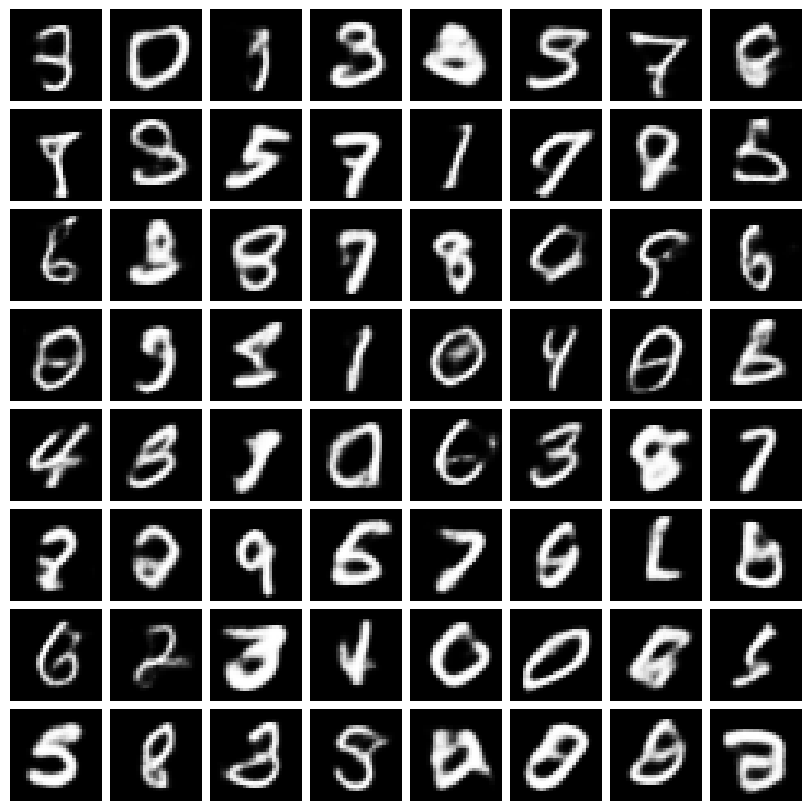

In [9]:
## generate new images by VAE

n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)

fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

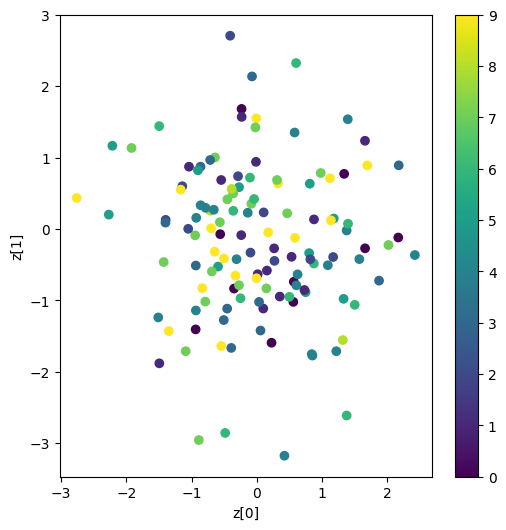

In [10]:
plot_latent_space(epochs)

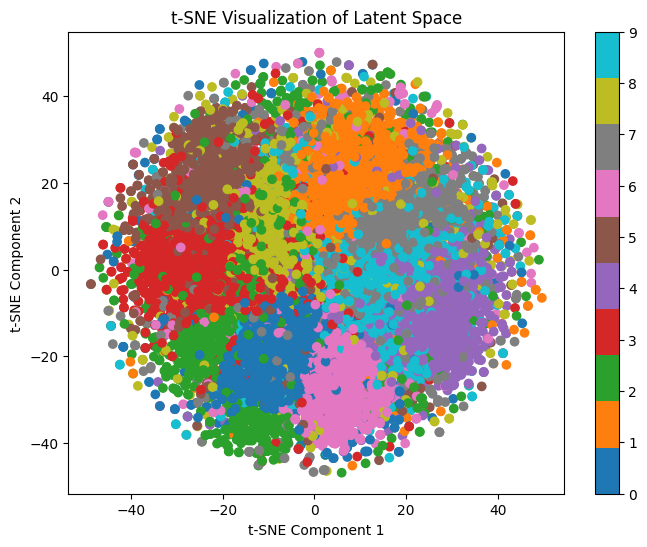

In [11]:
from sklearn.manifold import TSNE


# Visualize the latent space using t-SNE
def plot_latent_space_tsne():
    model.eval()
    with torch.no_grad():
      latent_vectors = []
      labels = []
      for data, label in test_loader:
        data = data.to(device)
        _, mu, logvar = model(data)
        z = model.reparameterize(mu, logvar)
        latent_vectors.append(z.cpu())
        labels.append(label)
      latent_vectors = torch.cat(latent_vectors, dim=0)
      labels = torch.cat(labels, dim=0)

      # Perform t-SNE
      tsne = TSNE(n_components=2, random_state=0)
      latent_tsne = tsne.fit_transform(latent_vectors)

      # Plot t-SNE
      plt.figure(figsize=(8, 6))
      plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10')
      plt.colorbar()
      plt.xlabel('t-SNE Component 1')
      plt.ylabel('t-SNE Component 2')
      plt.title('t-SNE Visualization of Latent Space')
      plt.show()

plot_latent_space_tsne()